<a href="https://colab.research.google.com/github/SaintSeong/SpartaCoding_AI/blob/main/%EC%8B%AC%ED%99%94_%EA%B3%BC%EC%A0%9C(Plot3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 로드 및 전처리


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from matplotlib import pyplot as plt
import numpy as np


# CIFAR10 데이터셋 로드

In [2]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 170498071/170498071 [00:10<00:00, 16328560.22it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# 데이터 로더 생성

In [3]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

# 데이터 Shape 확인




In [4]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


# 모델 정의

In [5]:
device = "cuda"

class Model_LeakyReLU_Dropout(nn.Module):
  def __init__(self, input_dim, n_dim, dropout_prob=0.1):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()
    self.dropout = nn.Dropout(dropout_prob)

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.dropout(x)
    x = self.act(self.layer2(x))
    x = self.dropout(x)
    x = self.act(self.layer3(x))

    return x

model = Model_LeakyReLU_Dropout(32*32*3, 1024)


# 모델, 옵티마이저 설정

In [6]:
from torch.optim import Adam

lr_Adam = 0.001

model = model.to(device)
optimizer = Adam(model.parameters(), lr=lr_Adam)

# 정확도 및 플롯 함수 정의

### from Gemini
정확도 함수에서 with torch.no_grad():와 model.eval()을 사용하는 이유는 모델 평가를 위한 환경을 설정하기 위해서입니다.

with torch.no_grad():는 gradient 계산을 비활성화합니다.

정확도 계산은 모델의 가중치를 업데이트하지 않으므로 gradient 계산이 필요하지 않습니다.
gradient 계산을 비활성화하면 메모리 사용량을 줄이고 계산 속도를 높일 수 있습니다.
model.eval()은 모델을 평가 모드로 설정합니다.

Dropout, Batch Normalization과 같은 layer들은 학습과 평가 모드에서 다르게 동작합니다.
model.eval()을 통해 모델이 평가 모드에서 동작하도록 하여 정확한 평가 결과를 얻을 수 있습니다.
요약하자면, 정확도 함수에서 이 두 코드를 사용하는 것은 gradient 계산을 비활성화하고 모델을 평가 모드로 설정하여 메모리 사용량을 줄이고, 계산 속도를 높이며, 정확한 평가 결과를 얻기 위함입니다.

In [7]:
def accuracy(model, dataloader):

  with torch.no_grad():
    model.eval()

  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

n_epochs = 50
train_acc= [];
test_acc = [];

# 모델 학습
### from Gemini
Dropout은 모델 학습 중에 랜덤하게 뉴런을 비활성화하여 overfitting을 방지하는 regularization 기술입니다.

model.train()을 설정하는 이유는 Dropout이 학습 시에만 적용되어야 하기 때문입니다.

model.train() 모드에서는 Dropout이 활성화되어 뉴런들이 랜덤하게 drop됩니다.
model.eval() 모드에서는 Dropout이 비활성화되어 모든 뉴런이 사용됩니다.
즉, model.train()을 통해 Dropout을 활성화하여 학습 중에만 Dropout을 적용하고,
평가 시에는 모든 뉴런을 사용하여 모델의 성능을 정확하게 측정할 수 있습니다.

In [8]:
for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    loss = nn.CrossEntropyLoss()(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  train_acc.append(accuracy(model, trainloader))
  test_acc.append(accuracy(model, testloader))
  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 430.83521151542664
Epoch   1 | Loss: 389.3031965494156
Epoch   2 | Loss: 367.9116442203522
Epoch   3 | Loss: 352.8257406949997
Epoch   4 | Loss: 342.23925602436066
Epoch   5 | Loss: 332.40001106262207
Epoch   6 | Loss: 323.61879801750183
Epoch   7 | Loss: 316.3290969133377
Epoch   8 | Loss: 310.3277180194855
Epoch   9 | Loss: 303.37165224552155
Epoch  10 | Loss: 299.41939532756805
Epoch  11 | Loss: 294.1680190563202
Epoch  12 | Loss: 289.45959734916687
Epoch  13 | Loss: 286.7505533695221
Epoch  14 | Loss: 281.2248874902725
Epoch  15 | Loss: 278.0865057706833
Epoch  16 | Loss: 275.0924080610275
Epoch  17 | Loss: 284.5276516675949
Epoch  18 | Loss: 271.4222722053528
Epoch  19 | Loss: 269.11881482601166
Epoch  20 | Loss: 265.3224867582321
Epoch  21 | Loss: 261.8641757965088
Epoch  22 | Loss: 259.88821828365326
Epoch  23 | Loss: 255.00502943992615
Epoch  24 | Loss: 254.6808284521103
Epoch  25 | Loss: 250.62838399410248
Epoch  26 | Loss: 247.52969896793365
Epoch  27 | Loss

# 정확도 Plot 보여주기

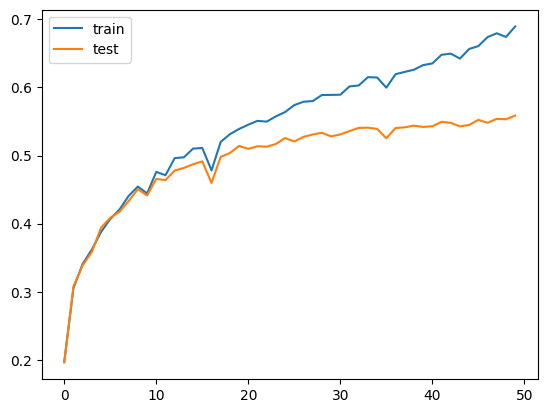

In [9]:
plot_acc(train_acc, test_acc)